In [1]:
# timer to time the whole notebook
import time
start_time = time.time()

1. Data Cleaning  
    1.1 Gain basic CSV overview  
    1.2 Formatiing NaN values    
    1.3 Transforming Coordinates  
    1.4 Transforming Timestamps  
    1.5 Checking for duplicates  
  
2. Data Overview  
    2.1 Gain Overview of data  
    2.2 Plot Hurricanes

3. Feature Engineering  
    3.1 Distance, Speed and Bearing to previous data point/s     
    3.2 Low/Moderate/High Wind Average Heading and Strength  
    3.3 Cleaning of created features  
    3.4 Correlation of created features  

1.1 Gain basic CSV overview

In [2]:
# import basic libs
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Point, Polygon
import warnings
import math
# surpress warnings such as deprecation notices
warnings.filterwarnings("ignore")

In [3]:
# import csv as pd
data = pd.read_csv("data/atlantic.csv")

In [4]:
""" Plotting column an row aounts & header"""
print("Pandas Dataframe Info:\n")
data.info()
print("\n\nPandas DataFrame Head:\n")
data.head()

Pandas Dataframe Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49105 entries, 0 to 49104
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                49105 non-null  object
 1   Name              49105 non-null  object
 2   Date              49105 non-null  int64 
 3   Time              49105 non-null  int64 
 4   Event             49105 non-null  object
 5   Status            49105 non-null  object
 6   Latitude          49105 non-null  object
 7   Longitude         49105 non-null  object
 8   Maximum Wind      49105 non-null  int64 
 9   Minimum Pressure  49105 non-null  int64 
 10  Low Wind NE       49105 non-null  int64 
 11  Low Wind SE       49105 non-null  int64 
 12  Low Wind SW       49105 non-null  int64 
 13  Low Wind NW       49105 non-null  int64 
 14  Moderate Wind NE  49105 non-null  int64 
 15  Moderate Wind SE  49105 non-null  int64 
 16  Moderate Wind SW  49105 non-null  

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


We see that 22 columns are available, containing 49104 rows with hurricane data points.  
For now, the following info is important:  
- Unique IDs
- Hurricanes ordered by 'string' names
- Date and time are in separate rows -> maybe they should be converted to datetime format
- coordinates are objects, likely shapely -> Since the bearing will be calculated manualy, the coordinates shall be converted to numbers
- the int value -999 is most likely the NaN value -> Conversion to proper numpy.nan

# 1.2 Formating NaN values  
Using the pd.replace() method, all numerical -999 values are replaced with the proper numpy NaN data type

In [5]:
"""convert -999 & -99 to NaN"""
data = data.replace(-999,np.NaN)
data = data.replace(-99,np.NaN)

# 1.3 Transforming Coordinates  
By iterating over the latitude and longitude strings, the last index is checked. The string is then transformed into floats and based on the heading turned negative or not.

In [6]:
"""convert string coordiantes no numerical"""
# empty list to append to
lat_transformed = []
# iterate over dataframe lat
for i in data["Latitude"]:
    # initiate and clear variable to hold string first then converted float
    # tmp_val = 0
    # check if N at end
    if i[-1]=="N":
        # assign temp value, exclude last index (N), convert to float
        tmp_val = float(i[:-1])
    #check if S at the end
    if i[-1]=="S":
        # assign temp value, exclude last index (N), convert to float
        # substract double the amount to get same value in negative
        tmp_val =  float(i[:-1]) - (float(i[:-1])*2)
    # append temp value to lat list
    lat_transformed.append(tmp_val)

#empty list to append to
lon_transformed = []
# iterate over dataframe lon
for i in data["Longitude"]:
    # check if E at end
    if i[-1]=="E":
        # assign temp value, exclude last index (N), convert to float
        tmp_val = float(i[:-1])
    # check if W at the end
    if i[-1]=="W":
        # assign temp value, exclude last index (N), convert to float
        # substract double the amount to get same value in negative
        tmp_val =  float(i[:-1]) - (float(i[:-1])*2)
    # append temp value to lon list
    lon_transformed.append(tmp_val)

# update lat and lon columns with the transformed info
data["Latitude"] = lat_transformed
data["Longitude"] = lon_transformed
del i, lat_transformed,lon_transformed,tmp_val

# 1.4 Transforming Timestamps  
Since the time and date are in different columns and not the proper data types, the two columns are iterated over and concatenated. using the datetime library, the resulting string is then turned into the datetime datatype. For that to happen, the information is unified by adding leading zeros to the hour&minute information, so that the format information can be passed to the strptime() function.

In [7]:
"""transform date & time columns to datetime format"""
import datetime as dt
import time
# empty list that holds tiemstamps
timestamps = []
# iterate over date and time
for date,time in zip(data["Date"],data["Time"]):
    # adding leading zeroes to time until length = 4
    while len(str(time)) < 4:
        time = str(0)+str(time)
    # concatenating date and time separated by space, appending 00 for the seconds
    timestamp = str(date) + " " + str(time) + "00"
    # transform string via strptime, passing format info
    timestamps.append(dt.datetime.strptime(timestamp, "%Y%m%d %H%M%S"))
# append dataframe with timestamps list
data["Timestamp"] = timestamps
data.drop(["Date","Time"], axis = 1, inplace = True)
del date,time,timestamp

# 1.5 Checking for Duplicates

Since there are no unique datapoint identifiers, the only way duplicates cam be detected is by seeing if a certain combination of attributes occurs in more than one row. For that, it is checked if/how many duplicates the pd.duplicated() function finds.

In [8]:
counter_false = 0
counter_true = 0
for i in data.duplicated():
    if i == True:
        counter_true = counter_true + 1
    else:
        counter_false = counter_false + 1
print("No. of duplicates in DF:\t"+str(counter_true))
print("No. of unique rows in DF:\t"+str(counter_false))
del counter_false,counter_true,i

No. of duplicates in DF:	0
No. of unique rows in DF:	49105


In [9]:
data.describe()

,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49105.000000,48767.000000,18436.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000
mean,27.044904,-65.682533,53.051695,992.244250,81.865394,76.518325,48.647188,59.156393,24.641952,23.029894,15.427293,18.403141,8.110117,7.357710,5.130890,6.269211
std,10.077880,19.687240,24.747884,19.113748,88.097930,87.563153,75.209183,77.568911,41.592337,42.017821,32.105372,35.411258,19.792002,18.730334,14.033464,16.876623
min,7.200000,-359.100000,10.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.100000,-81.000000,35.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.400000,-68.000000,50.000000,999.000000,60.000000,60.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.100000,-52.500000,70.000000,1006.000000,130.000000,120.000000,75.000000,90.000000,40.000000,35.000000,20.000000,30.000000,0.000000,0.000000,0.000000,0.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


# 2.1 Gain overview over data  
Now that some basic data cleaning and preparation was done, lets have a look at the data itself. The values that the columns exhibit are checked first.

In [10]:
"""uniqie values in IDs, Status"""
print("Unique IDs, therefore total number of Hurricanes: ",len(data.ID.unique()))
print("Average no. of data points per Hurricane: " + str(round( len(data)/len(data.ID.unique() ),2)))

status = []
for i in data.Status.unique():
    status.append(i)
print("\nunique 'Status' column values: "+str(status))

event = []
for i in data.Event.unique():
    event.append(i)
print("unique 'Event' column values: "+str(event))
del status,event,i

Unique IDs, therefore total number of Hurricanes:  1814
Average no. of data points per Hurricane: 27.07

unique 'Status' column values: [' HU', ' TS', ' EX', ' TD', ' LO', ' DB', ' SD', ' SS', ' WV']
unique 'Event' column values: ['  ', ' L', ' R', ' I', ' P', ' W', ' C', ' S', ' G', ' T']


Next up, lets check the range of the Latitude and Longitude values by plotting them against each other.  
Note that this is not a geographical plot yet since no projection is taken into account, rather only a way of finding clusters and outliers.

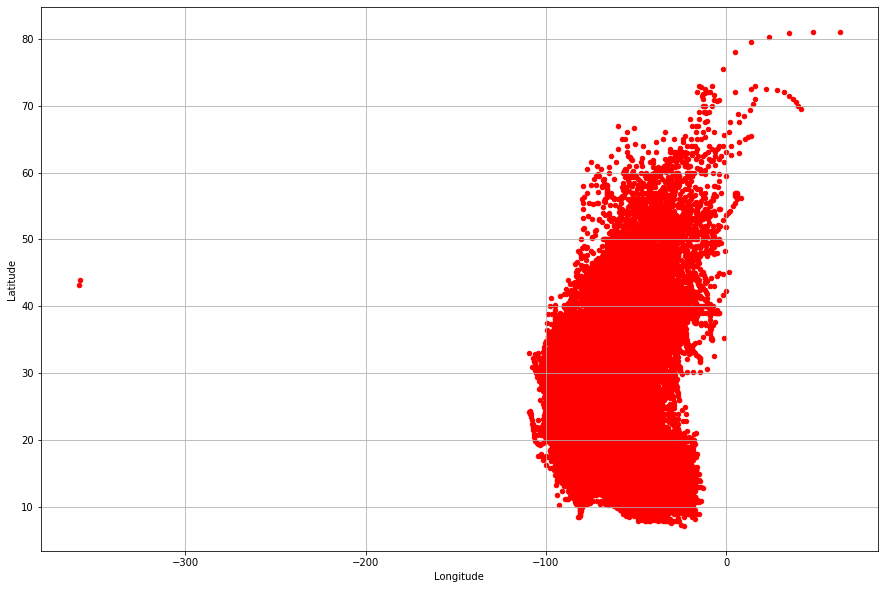

In [11]:
data.plot("Longitude","Latitude",kind="scatter",grid=True,color="red",figsize=(15,10))

Usually, statistical methods such as the standard deviation could be used to eleminate outliers. but in a case this clear, where a nice clustering is present and only a few outliers have Longitude values of under -300, we can manually eliminate them based on a threshold. For the outliers on the top right near the cluser, they are in a nice formation so that it seems logical that there was an exeptionally north and west storm on year, so no efforts to sliminate further storms will be made.  

Now, let's gain some statistical understanding of the numerical values.

In [12]:
data.describe()

,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49105.000000,48767.000000,18436.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000,5921.000000
mean,27.044904,-65.682533,53.051695,992.244250,81.865394,76.518325,48.647188,59.156393,24.641952,23.029894,15.427293,18.403141,8.110117,7.357710,5.130890,6.269211
std,10.077880,19.687240,24.747884,19.113748,88.097930,87.563153,75.209183,77.568911,41.592337,42.017821,32.105372,35.411258,19.792002,18.730334,14.033464,16.876623
min,7.200000,-359.100000,10.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.100000,-81.000000,35.000000,984.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.400000,-68.000000,50.000000,999.000000,60.000000,60.000000,0.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33.100000,-52.500000,70.000000,1006.000000,130.000000,120.000000,75.000000,90.000000,40.000000,35.000000,20.000000,30.000000,0.000000,0.000000,0.000000,0.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


Since the wind directions are separated in different columns and then set to zero if the wind doesnt come from that certain direction, the wind speed data points have mostly zero values. The 50 percentile is completely filled with those zero values for most of the columns. The zero values are therefore changed to np.NaN aswell.

,Latitude,Longitude,Maximum Wind,Minimum Pressure,Low Wind NE,Low Wind SE,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
count,49105.000000,49102.000000,48767.000000,18436.000000,3837.000000,3674.000000,2861.000000,3298.000000,2159.000000,1994.000000,1660.000000,1826.000000,1190.000000,1154.000000,992.000000,1031.000000
mean,27.044904,-65.686546,53.051695,992.244250,126.329163,123.316549,100.678085,106.205276,67.579898,68.385155,55.027108,59.674151,40.352941,37.751300,30.625000,36.003880
std,10.077880,19.681145,24.747884,19.113748,79.744560,81.149871,80.425082,76.193733,42.925243,46.271414,38.701215,40.043340,25.459639,25.551839,19.872512,23.778631
min,7.200000,-359.100000,10.000000,882.000000,10.000000,10.000000,10.000000,10.000000,5.000000,5.000000,10.000000,10.000000,10.000000,10.000000,5.000000,10.000000
25%,19.100000,-81.000000,35.000000,984.000000,70.000000,60.000000,45.000000,50.000000,40.000000,30.000000,30.000000,30.000000,20.000000,20.000000,15.000000,20.000000
50%,26.400000,-68.000000,50.000000,999.000000,105.000000,100.000000,75.000000,90.000000,60.000000,60.000000,45.000000,50.000000,30.000000,30.000000,25.000000,30.000000
75%,33.100000,-52.500000,70.000000,1006.000000,160.000000,150.000000,120.000000,140.000000,90.000000,90.000000,70.000000,75.000000,50.000000,50.000000,40.000000,50.000000
max,81.000000,63.000000,165.000000,1024.000000,710.000000,600.000000,640.000000,530.000000,360.000000,300.000000,330.000000,360.000000,180.000000,250.000000,150.000000,180.000000


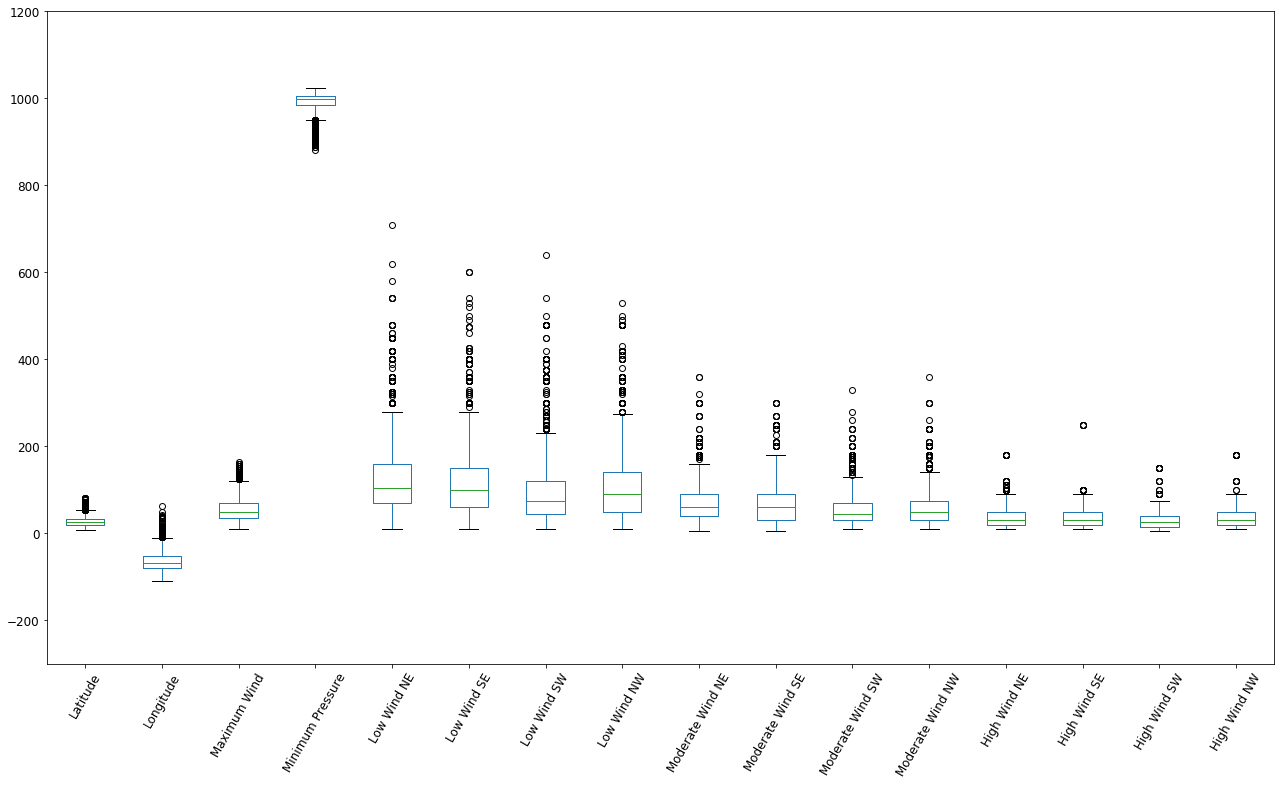

In [13]:
data = data.replace(0,np.NaN)
data.plot(kind="box",figsize=(22,12),rot=60,ylim=((-300,1200)),fontsize='large')
data.describe()

As usual, the boxes of the boxplot extend from Q1 to Q3 with the median line in the middle. Here, the whiskers extend up to the farthest data point within interquartal range ( 1,5*(Q3-Q1) ), the individual data points plotted as dots are considered outliers in this example.  
As seen before, the Longitude outliers are quite prominent here. Especially for the low wind data directional data points, quite a few outliers are detected, but some aswell for the high wind directional data points. Since the wind data itself will only be used to calculate the wind direction vector bearing and strength, there is no need at this point to remove the wind outliers.

In [14]:
""" Removing Longitude outlier rows """
len_before = len(data)
data = data[(data["Longitude"] > -300)]
print("Removed " + str(len_before-len(data)) + " rows with Latitude value lower than -300.")
del len_before

Removed 5 rows with Latitude value lower than -300.


# 2.2 Plot Hurricanes
Now, lets plot some hurricanes from selected years to have a look at their distributions. For that, the pandas dataframe is converted to geopandas and the gpd df assigned the SRS 4326. The plotting is executed in a method so that we can call the method later on again to plot certain hurricanes. The gpd is deleted afterwards, since we will continue working with the pd dataframe.

In [ ]:
def plot_hurricanes(data,years):
    import geopandas as gpd
    import geoplot
    # convert to gpd based on geometries
    gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude,data.Latitude))
    # set SRS
    gdf = gdf.set_crs(epsg=4326)

    """get total bounding box """
    bb_all = gdf.bounds
    bb_min_x = bb_all["minx"].min() - 5
    bb_min_y = bb_all["miny"].min() - 5
    bb_max_x = bb_all["maxx"].max() + 5
    bb_max_y = bb_all["maxy"].max() + 5

    """ plot all hurricanesof certain years, color coded by IDs """
    # get world boundaries
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    # create ax and plot world
    ax = world.plot(color='white', edgecolor='black',figsize=(20,20))
    # set limits from BBs
    ax.set_xlim(bb_min_x, bb_max_x)
    ax.set_ylim(bb_min_y, bb_max_y)

    # cyle through IDs, filter by years, plot each point
    hur_ls = gdf["ID"].unique()
    hur_ls_years = []
    for i in hur_ls:
        if int(i[4:]) in years:
            hur_ls_years.append(i)
    print("No. of Hurricanes in "+str(years)+": ",len(hur_ls_years))
    for hur in hur_ls_years:
        hur_point = gdf[(gdf["ID"].str.contains(hur))]
        hur_point.plot(ax=ax)

    del bb_all,bb_min_y,bb_max_x,bb_max_y,world,ax,years,hur_ls,hur_ls_years,i,hur,hur_point

plot_hurricanes(data,[1990,1991,1992,1993,1994])

No. of Hurricanes in [1990, 1991, 1992, 1993, 1994]:  60


# 3. Feature Engineering  
Now, we create the features that the prediciton will be based on  
# 3.1 Distance, Speed and Bearing to previous data point/s  

...Explain distance  
...Explain speed  
The bearing is calculated according to https://gist.github.com/jeromer/2005586 (published with a public domain licens) from the hurricane point to the -n point in time (in this case 1,2,5,10).

In [ ]:
import haversine

# returns compass bearing for 2 points
def get_bearing(pointA, pointB):
    import math
    """ taken from https://gist.github.com/jeromer/2005586, public domain license"""
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")
    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])
    diffLong = math.radians(pointB[1] - pointA[1])
    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)* math.cos(lat2) * math.cos(diffLong))
    initial_bearing = math.atan2(x, y)
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360
    return compass_bearing



ids = list(data["ID"])
lon = list(data["Longitude"])
lat = list(data["Latitude"])
loc_tuples = []
timestamp = list(data["Timestamp"])
unique_hurricanes = list(data["ID"].unique())

# create location tuples list
for a,b in zip(lon,lat):
    loc_tuples.append((a,b))

# Calculate distance, speed and bearing to previous data point/s
def calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,data_point):
    # iteration structure adapted with permission from 'distance calculation' by Gil Salvans
    # https://github.com/gilsalvans/WS_DataScience_SalvansTorras/blob/main/Salvans_notebook_20W856113.ipynb (Field 33)
    # additionally implemented speed and bearing calc
    # additionally implemented dynamic choice of how far back in time the data is taken
    distance = []
    speed = []
    bearing = []
    for i in range(len(ids)):
        if ids[i] == ids[i-data_point]: 
            try:
                #calculate distance
                loc1 = loc_tuples[i-data_point]
                loc2 = loc_tuples[i]
                dist = haversine.haversine(loc1,loc2)
                dist = round(dist,2)
                
                
                #calculate speed
                tim1 = timestamp[i-data_point]
                tim2 = timestamp[i]
                duration = tim2 - tim1 # diffrence in timestamp (time format)
                duration_in_s = duration.total_seconds() # convert difference to seconds
                
                
                # calculate speed in kmh formula: (dist in m / time in s) = meter/second ... *3,6 = speed in km/h
                speed_kmh = round(((dist*1000)/duration_in_s)*3.6,2)
               
                # calculate bearing between two points, round to 2 dec
                bearing_temp = round(get_bearing(loc1,loc2),2)
                
                # divide distance by data point before appending, giving the average distance per data point over the last 10 data points
                dist = dist/data_point
                
                # append values to list
                distance.append(dist) # append distance in m to list
                speed.append(speed_kmh)
                bearing.append(bearing_temp)
                
                
            # catch errors
            except:
                distance.append(np.nan)
                speed.append(np.nan)
                bearing.append(np.nan)
        
        # if no data point in time -n
        else:
            distance.append(np.nan)
            speed.append(np.nan)
            bearing.append(np.nan)
    
    #remove 0 values from lists
    for n, i in enumerate(distance):
        if i == 0:
            distance[n] = np.NaN
    for n, i in enumerate(speed):
        if i == 0:
            speed[n] = np.NaN
    for n, i in enumerate(bearing):
        if i == 0:
            bearing[n] = np.NaN
    
    # return lists w/ calculated & cleaned values
    return distance,speed,bearing


# call function and save results to list
distance_1,speed_1,bearing_1 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,1)
distance_2,speed_2,bearing_2 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,2)
distance_5,speed_5,bearing_5 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,5)
distance_10,speed_10,bearing_10 = calculate_dist_speed_bearing_from_loc(ids,loc_tuples,timestamp,10)

# append results to pd.DF
data["distance_1"], data["speed_1"], data["bearing_1"] = [distance_1,speed_1,bearing_1]
data["distance_2"], data["speed_2"], data["bearing_2"] = [distance_2,speed_2,bearing_2]
data["distance_5"], data["speed_5"], data["bearing_5"] = [distance_5,speed_5,bearing_5]
data["distance_10"], data["speed_10"], data["bearing_10"] = [distance_10,speed_10,bearing_10]


# 3.2 Bearing  

# 3.3 Low/Moderate/High Wind Average Heading and Strength

Since the wind strengths are split up in the 4 directions per low/moderate/high zone, these cam be aggregated. The goal is to calculate the total bearing by combining all directional vectors and the according strength of the wind. 
  
The bearing is calculated by the following schema:  
![schema image](https://www.donike.net/wp-content/uploads/wind_bearing_schema.png "Schema Image")  
  
The orange cross represents the bearing directions as given by the original data, since they are in North West etc. The red points show the according values along those axes, while the green cross represents the point of both bearing (angle to origin) and wind strength (distance from origin), having weighted the vector against each other. The point is calculated by the following formula:  
x = ( (SW+SE)/2 ) -  ( (NW+NE)/2 )  
y = ( (NW+SW)/2 ) -  ( (NE+SE)/2 )  
distance from point to origin: sqrt( ((x2-x1)^2) + ((y2-y1)^2) )  

The bearing is then calculated according to https://gist.github.com/jeromer/2005586 from the origin to the point. Then, this number needs to be corrected since the original data is not given in the 4 cardinal directions, while the bearing calculator returns a compass heading. For that, 90 is added to the compass bearing; if the bearing would rise over 360 it is corrected again to represent a normal positive bearing.  
This process is repeated for low, moderate, and high winds and yields the strength and speed as returns for each.

In [ ]:
"""Append aggregated wind bearing and strength to data"""

# Order: "Low Wind NE","Low Wind SE","Low Wind SW","Low Wind NW"
low_wind = [list(data["Low Wind NE"]),list(data["Low Wind SE"]),list(data["Low Wind SW"]),list(data["Low Wind NW"])]
mod_wind = [list(data["Moderate Wind NE"]),list(data["Moderate Wind SE"]),list(data["Moderate Wind SW"]),list(data["Moderate Wind NW"])]
high_wind = [list(data["High Wind NE"]),list(data["High Wind SE"]),list(data["High Wind SW"]),list(data["High Wind NW"])]



def get_distance(x1,y1,x2,y2):
    return math.sqrt( ((x2-x1)**2) + ((y2-y1)**2) )


# returns distance of wind avg. point as well as bearing
def get_wind_info(wind_list):
    wind_strength = []
    wind_bearing = []
    for NE,SE,SW,NW in zip(wind_list[0],wind_list[1],wind_list[2],wind_list[3]):
        if math.isnan(NE)==True:
            NE = 0
        if math.isnan(SE)==True:
            SE = 0
        if math.isnan(SW)==True:
            SW = 0
        if math.isnan(NW)==True:
            NW = 0
        ns_agg = ( (SW+SE)/2 ) -  ( (NW+NE)/2 )
        we_agg = ( (NW+SW)/2 ) -  ( (NE+SE)/2 )

        wind_strength.append(get_distance(0,0,we_agg,ns_agg))
        wind_bearing.append(get_bearing((0,0),(we_agg,ns_agg)))
        
    # add 90 to turn diagonal compass cross upright and correct compass bearing
    wind_bearing_corrected = []
    counter=0
    for i in wind_bearing:
        if i!=0:
            i = i+90
            # if result over 90, substract 360 to "swing around" value back to positive bearing
            if i >=360:
                i = i-360
            wind_bearing_corrected.append(i)
        else:
            wind_bearing_corrected.append(0)
    
    wind_bearing = wind_bearing_corrected
    return wind_strength,wind_bearing

low_wind_strength,low_wind_bearing = get_wind_info(low_wind)
mod_wind_strength, mod_wind_bearing = get_wind_info(mod_wind)
high_wind_strength, high_wind_bearing = get_wind_info(high_wind)

data["Low Wind Directional Strength"] = low_wind_strength
data["Moderate Wind Directional Strength"] = mod_wind_strength
data["High Wind Directional Strength"] = high_wind_strength
data["Low Wind Bearing"] = low_wind_bearing
data["Moderate Wind Bearing"] = mod_wind_bearing
data["High Wind Bearing"] = high_wind_bearing

# since the zero values in the newly created columns are 0 if there is no info, they are translated back to np.NaN
data["Low Wind Directional Strength"] = data["Low Wind Directional Strength"].replace(0,np.NaN)
data["Moderate Wind Directional Strength"] = data["Moderate Wind Directional Strength"].replace(0,np.NaN)
data["High Wind Directional Strength"] = data["High Wind Directional Strength"].replace(0,np.NaN)
data["Low Wind Bearing"] = data["Low Wind Bearing"].replace(0,np.NaN)
data["Moderate Wind Bearing"] = data["Moderate Wind Bearing"].replace(0,np.NaN)
data["High Wind Bearing"] = data["High Wind Bearing"].replace(0,np.NaN)

# dropping the wind values that were aggregated
data = data.drop(["Low Wind NE","Low Wind NW","Low Wind SE","Low Wind SW" ], axis=1)
data = data.drop(["Moderate Wind NE","Moderate Wind NW","Moderate Wind SE","Moderate Wind SW" ], axis=1)
data = data.drop(["High Wind NE","High Wind NW","High Wind SE","High Wind SW" ], axis=1)

del low_wind_strength,mod_wind_strength,high_wind_strength,low_wind_bearing,mod_wind_bearing,high_wind_bearing

In [ ]:
""" Lets look at the statistics for the newly created values"""
data.describe()

Judging by the bearing, which are mostly in the range of 270, the process seems to have worked. As evident by the map and the behaviour of hurricanes, they usually move West or West-South-West over the atlantic, which corresponds to the mean heading of about 250-260° for each wind altitude zone.  
The mean directional strength wind speed also nicely fits to the mean wind speeds of the altitude zones, having the highest values (ca. 75 and 71 for the directional wind) at the bottom, moderate values (ca. 45 and 37 for the directional wind) in the middle and then the lowest values (ca. 35 and 22 for the directional wind) at the top. It makes sense that the directional values are lower, since measured winds in different directions cancel each other out and therefore lower the calculated value.

### mark distance as km per hour to have same values? Otherwise 10 datapoints ago might not be always exactly 60hrs ago if more data points are available?

Now that the feature engineering is complete, lets have a look at the statistica distributions for our features.

In [ ]:
data.plot(kind="box",figsize=(22,12),rot=60,ylim=((-200,1800)),fontsize='large')
data.describe()

In [ ]:
data.corr(method='pearson')

# MASK WATER

In [ ]:
""" Point sampling to check if point over water, adding column with country info """
# Loarding world shape as gpd.df, removing unseless column
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


from geopandas.tools import sjoin
#transform pd.df to geopandas df
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude,data.Latitude))
# set SRS
gdf = gdf.set_crs(epsg=4326)
# spatial hoin of data and world, adding world info to data
gdf = sjoin(gdf, world, how='left')
world = world.drop(["gdp_md_est"],axis=1)
 
gdf = gdf.drop(["gdp_md_est","index_right","pop_est","continent","name"],axis=1)
gdf.info()

Now that the dataframe contains a column that indicates the country in which that point falls (nan if it is over water), a plot is created to make sure that the spatial join worked and the projections were correct.

In [ ]:
""" Plotting points identifies as over water """
# set up ax with world as background
ax = world.plot(color='white', edgecolor='black',figsize=(20,20))
# get unique country series
countries = gdf["iso_a3"].unique()
# plot all points in gray as background
gdf.plot(ax=ax,zorder=0,color="gray")
# plot points by individual country to get dif colors
for i in countries:
    if i != np.nan:
        hur_point = gdf[ (gdf["iso_a3"]==i)]
        hur_point.plot(ax=ax)

In [ ]:
import time
end_time=time.time()
print("Total runtime of Notebook: "+str(int(end_time-start_time))+"s")